# Preparación de los Datos
[Bank Marketing](https://archive.ics.uci.edu/dataset/222/bank+marketing)
Datos de una campaña de marketing bancario. Predice si un cliente suscribirá un depósito a plazo fijo.
En este notebook se muestran algunos de los mecanismos más utilizados para la división del conjunto de datos.

## Conjunto de datos

### Descripción

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

There are four datasets:

1. bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
2. bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
3. bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs).
4. bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs).
   The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM).

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

### Ficheros de datos

- <span style="color:green">bank.zip</span>
- <span style="color:green">bank-additional.zip</span>

### Descarga de los ficheros de datos

[Enlace](https://archive.ics.uci.edu/static/public/222/bank+marketing.zip)

### Adicional Variable Información

Input variables:

#### bank client data:

1. age (numeric)
2. job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
"blue-collar","self-employed","retired","technician","services")
3. marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
4. education (categorical: "unknown","secondary","primary","tertiary")
5. default: has credit in default? (binary: "yes","no")
6. balance: average yearly balance, in euros (numeric)
7. housing: has housing loan? (binary: "yes","no")
8. loan: has personal loan? (binary: "yes","no")

#### related with the last contact of the current campaign:

9. contact: contact communication type (categorical: "unknown","telephone","cellular")
10. day: last contact day of the month (numeric)
11. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
12. duration: last contact duration, in seconds (numeric)

#### other attributes:

13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
15. previous: number of contacts performed before this campaign and for this client (numeric)
16. poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

Output variable (desired target):
17. y has the client subscribed a term deposit? (binary: "yes","no")


## Funciones Genéricas

In [1]:
%pip install pandas
%pip install scikit-learn
%matplotlib inline

import arff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Función para cargar el dataset
def load_dataset(data_path, delimiter=';'):
    df = pd.read_csv(data_path, delimiter=delimiter)
    pd.set_option('display.max_columns', None)
    return df

# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return train_set, val_set, test_set

## 1. Debemos dividir el conjunto de datos

In [3]:
df_orig = load_dataset("./datasets/bank+marketing/bank/bank-full.csv")
df = df_orig.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
# Separamos el conjunto de datos 60% train set, 40% test set
train_set, test_set = train_test_split(df, test_size=0.4, random_state=42)

In [5]:
train_set.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
6377,45,entrepreneur,married,primary,no,-100,yes,no,unknown,27,may,240,6,-1,0,unknown,no
17236,29,services,single,secondary,no,166,no,yes,cellular,28,jul,108,8,-1,0,unknown,no
4490,31,admin.,single,secondary,no,121,yes,no,unknown,20,may,187,1,-1,0,unknown,no
24231,40,self-employed,single,tertiary,no,1693,yes,no,cellular,17,nov,353,1,-1,0,unknown,no
3978,28,services,single,secondary,no,317,yes,no,unknown,16,may,21,3,-1,0,unknown,no


In [6]:
test_set.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
3776,40,blue-collar,married,secondary,no,580,yes,no,unknown,16,may,192,1,-1,0,unknown,no
9928,47,services,single,secondary,no,3644,no,no,unknown,9,jun,83,2,-1,0,unknown,no
33409,25,student,single,tertiary,no,538,yes,no,cellular,20,apr,226,1,-1,0,unknown,no
31885,42,management,married,tertiary,no,1773,no,no,cellular,9,apr,311,1,336,1,failure,no
15738,56,management,married,tertiary,no,217,no,yes,cellular,21,jul,121,2,-1,0,unknown,no


In [7]:
# Separamos el conjunto de datos de pruebas 50% validation set, 50% test set
val_set, test_set = train_test_split(test_set, test_size=0.5, random_state=42)

In [8]:
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del Training Set: 27126
Longitud del Validation Set: 9042
Longitud del Test Set: 9043


Ya tenemos separado nuesto dataset :
* 60% Entrenamiento
* 20% Validación
* 20% Test 

### También es buena práctica el particionado aleatorio y Stratified Sampling

La función **train_test_split** de Sklearn realiza particiones aleatorias por defecto cada vez que se ejecuta el script.  
Incluso con una semilla fija, al recargar el conjunto de datos se generan nuevos subconjuntos, lo que puede hacer que el algoritmo termine "viendo" todos los datos.  
Para resolverlo, Sklearn introduce el parámetro **shuffle** en **train_test_split**.


In [9]:
# Si shuffle=False, el conjunto de datos no se mezclará antes del particionado
train_set, test_set = train_test_split(df, test_size=0.4, random_state=42, shuffle=False)

- Si tu conjunto de datos es pequeño, dividirlo sin cuidado puede introducir **sampling bias**, dejando algunas características sin representación en los subconjuntos.  
- Para evitarlo, se usa **Stratified Sampling**, que crea subconjuntos homogéneos (**strata**) para mantener las proporciones originales.  
- En **Scikit-learn**, el parámetro **stratify** de **train_test_split** asegura esta distribución.


In [10]:
#Elegimos la columna "y" para hacer el stratify como ejemplo
train_set, test_set = train_test_split(df, test_size=0.4, random_state=42, stratify=df["y"])

#### Función de particionado

In [11]:
print("Longitud del conjunto de datos:", len(df))

Longitud del conjunto de datos: 45211


In [12]:
train_set, val_set, test_set = train_val_test_split(df, stratify='y')

In [13]:
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del Training Set: 27126
Longitud del Validation Set: 9042
Longitud del Test Set: 9043


##### Visualizamos la distribución

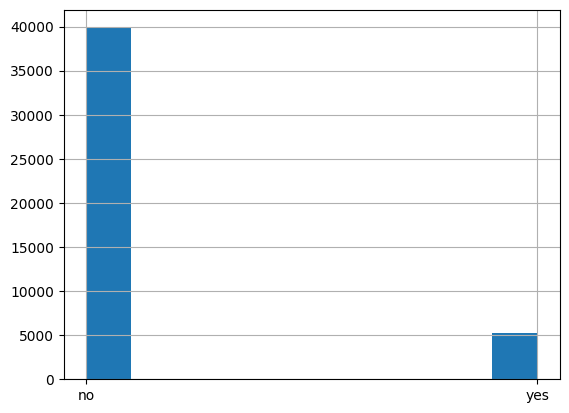

In [14]:
df["y"].hist()
plt.show()

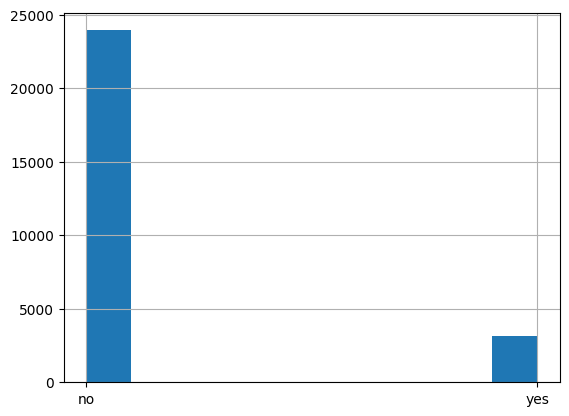

In [15]:
train_set["y"].hist()
plt.show()

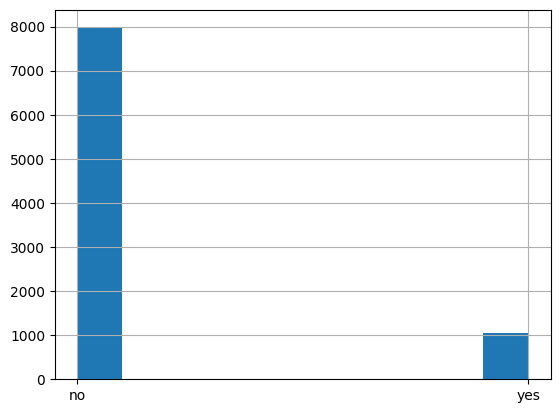

In [16]:
val_set["y"].hist()
plt.show()

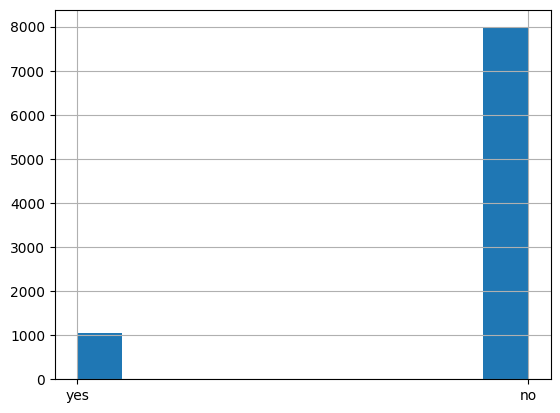

In [17]:
test_set["y"].hist()
plt.show()

## 2. Comprobar si existen atributos nulos

In [18]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


### Limpiamos los datos

Antes de comenzar, vamos a recuperar el conjunto de datos limpio y vamos a separar las etiquetas del resto de los datos, no necesariamente queremos aplicar las mismas transformaciones en ambos conjuntos.

In [19]:
# Separamos las características de entrada de la característica de salida
X_train = train_set.drop("y", axis=1) # Axis = 1 se refiere a columnas, si fuese 0 serían filas

In [20]:
# Comprobamos si existe algún atributo con valores nulos
X_train.isna().any()

age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
dtype: bool

**Como no tenemos datos nulos vamos a generarlo nosotros**

In [21]:
# Vamos a añadir algunos valores nulos
# elegimos algunas características del conjunto de datos, como day y duration
X_train.loc[(X_train["day"] > 10) & (X_train["day"] < 15), "day"] = np.nan
X_train.loc[(X_train["duration"] > 100) & (X_train["duration"] < 200), "duration"] = np.nan
X_train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
217,53,unemployed,married,unknown,no,13,no,no,unknown,5.0,may,410.0,3,-1,0,unknown
34160,54,technician,married,secondary,no,0,no,no,telephone,30.0,apr,766.0,3,84,3,success
34607,30,self-employed,single,secondary,no,280,no,no,telephone,5.0,may,92.0,3,-1,0,unknown
447,50,self-employed,married,unknown,no,-84,yes,no,unknown,6.0,may,NaN,1,-1,0,unknown
23636,60,self-employed,married,secondary,no,1690,no,no,cellular,28.0,aug,64.0,11,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14003,29,blue-collar,single,secondary,no,482,no,yes,cellular,10.0,jul,1097.0,3,-1,0,unknown
6317,30,blue-collar,married,secondary,no,1196,no,no,unknown,27.0,may,NaN,1,-1,0,unknown
34781,27,management,single,tertiary,no,2559,yes,no,cellular,6.0,may,227.0,1,-1,0,unknown
13679,32,housemaid,married,primary,no,0,yes,no,cellular,9.0,jul,90.0,1,-1,0,unknown


**Como vamos a comprobar ahora ya tendremos nulos en nuestro datos**

In [22]:
X_train.isna().any()

age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day           True
month        False
duration      True
campaign     False
pdays        False
previous     False
poutcome     False
dtype: bool

## 3. Opciones vistas en clase para la eliminación de nulos: 
1. Eliminar filas con nulos.
2. Eliminar atributos con nulos.
3. Rellenar nulos con media y mediana.

In [23]:
# Recogemos solo las filas que contienen valores nulos
filas_valores_nulos  = X_train[X_train.isnull().any(axis=1)]
filas_valores_nulos

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
447,50,self-employed,married,unknown,no,-84,yes,no,unknown,6.0,may,NaN,1,-1,0,unknown
21132,30,management,married,tertiary,no,1384,yes,no,telephone,NaN,aug,60.0,2,-1,0,unknown
36302,50,entrepreneur,married,primary,no,199,no,no,cellular,NaN,may,228.0,2,363,2,failure
36137,42,blue-collar,married,primary,no,659,yes,no,cellular,NaN,may,91.0,1,-1,0,unknown
2601,44,technician,married,secondary,no,3790,yes,no,unknown,NaN,may,342.0,2,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17316,27,self-employed,married,tertiary,no,0,no,yes,cellular,28.0,jul,NaN,4,-1,0,unknown
29431,31,blue-collar,married,tertiary,no,433,no,yes,cellular,3.0,feb,NaN,1,-1,0,unknown
1484,32,unemployed,single,tertiary,no,336,yes,no,unknown,8.0,may,NaN,1,-1,0,unknown
42231,28,self-employed,single,tertiary,no,805,no,no,cellular,NaN,nov,NaN,5,170,2,failure


### Opción 1: Eliminamos las filas con valores nulos

In [24]:
# Copiamos el conjunto de datos para no alterar el original
X_train_copy = X_train.copy()

In [25]:
# Eliminamos las filas con valores nulos
X_train_copy.dropna(subset=["day", "duration"], inplace=True) # inplace sustituye en el dataframe, no devuelve copia
X_train_copy

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
217,53,unemployed,married,unknown,no,13,no,no,unknown,5.0,may,410.0,3,-1,0,unknown
34160,54,technician,married,secondary,no,0,no,no,telephone,30.0,apr,766.0,3,84,3,success
34607,30,self-employed,single,secondary,no,280,no,no,telephone,5.0,may,92.0,3,-1,0,unknown
23636,60,self-employed,married,secondary,no,1690,no,no,cellular,28.0,aug,64.0,11,-1,0,unknown
22210,32,technician,single,tertiary,no,0,no,no,cellular,21.0,aug,660.0,2,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28667,31,services,single,secondary,no,297,no,no,cellular,30.0,jan,229.0,1,-1,0,unknown
14003,29,blue-collar,single,secondary,no,482,no,yes,cellular,10.0,jul,1097.0,3,-1,0,unknown
34781,27,management,single,tertiary,no,2559,yes,no,cellular,6.0,may,227.0,1,-1,0,unknown
13679,32,housemaid,married,primary,no,0,yes,no,cellular,9.0,jul,90.0,1,-1,0,unknown


In [26]:
# Contamos el número de filas eliminadas
print("El número de filas eliminadas es:", len(X_train) - len(X_train_copy))

El número de filas eliminadas es: 11026


### Opción 2: Eliminamos los atributos con valores nulos

In [27]:
# Copiamos el conjunto de datos para no alterar el original
X_train_copy = X_train.copy()

In [28]:
# Eliminamos los atributos con valores nulos
X_train_copy.drop(["day", "duration"], axis=1, inplace=True)
X_train_copy

,age,job,marital,education,default,balance,housing,loan,contact,month,campaign,pdays,previous,poutcome
217,53,unemployed,married,unknown,no,13,no,no,unknown,may,3,-1,0,unknown
34160,54,technician,married,secondary,no,0,no,no,telephone,apr,3,84,3,success
34607,30,self-employed,single,secondary,no,280,no,no,telephone,may,3,-1,0,unknown
447,50,self-employed,married,unknown,no,-84,yes,no,unknown,may,1,-1,0,unknown
23636,60,self-employed,married,secondary,no,1690,no,no,cellular,aug,11,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14003,29,blue-collar,single,secondary,no,482,no,yes,cellular,jul,3,-1,0,unknown
6317,30,blue-collar,married,secondary,no,1196,no,no,unknown,may,1,-1,0,unknown
34781,27,management,single,tertiary,no,2559,yes,no,cellular,may,1,-1,0,unknown
13679,32,housemaid,married,primary,no,0,yes,no,cellular,jul,1,-1,0,unknown


In [29]:
# Contamos el número de atributos eliminados
print("El número de atributos eliminados es:", len(list(X_train)) - len(list(X_train_copy)))
X_train.head()

El número de atributos eliminados es: 2


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
217,53,unemployed,married,unknown,no,13,no,no,unknown,5.0,may,410.0,3,-1,0,unknown
34160,54,technician,married,secondary,no,0,no,no,telephone,30.0,apr,766.0,3,84,3,success
34607,30,self-employed,single,secondary,no,280,no,no,telephone,5.0,may,92.0,3,-1,0,unknown
447,50,self-employed,married,unknown,no,-84,yes,no,unknown,6.0,may,NaN,1,-1,0,unknown
23636,60,self-employed,married,secondary,no,1690,no,no,cellular,28.0,aug,64.0,11,-1,0,unknown


### Opción 3: Rellenamos los valores nulos con un valor determinado

In [30]:
# Copiamos el conjunto de datos para no alterar el original
X_train_copy = X_train.copy()

In [31]:
# Rellenamos los valores nulos con la media de los valores del atributo
media_day = X_train_copy["day"].mean()
media_duration = X_train_copy["duration"].mean()

X_train_copy["day"] = X_train_copy["day"].fillna(media_day)
X_train_copy["duration"] = X_train_copy["duration"].fillna(media_duration)

X_train_copy

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
217,53,unemployed,married,unknown,no,13,no,no,unknown,5.0,may,410.000000,3,-1,0,unknown
34160,54,technician,married,secondary,no,0,no,no,telephone,30.0,apr,766.000000,3,84,3,success
34607,30,self-employed,single,secondary,no,280,no,no,telephone,5.0,may,92.000000,3,-1,0,unknown
447,50,self-employed,married,unknown,no,-84,yes,no,unknown,6.0,may,309.076133,1,-1,0,unknown
23636,60,self-employed,married,secondary,no,1690,no,no,cellular,28.0,aug,64.000000,11,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14003,29,blue-collar,single,secondary,no,482,no,yes,cellular,10.0,jul,1097.000000,3,-1,0,unknown
6317,30,blue-collar,married,secondary,no,1196,no,no,unknown,27.0,may,309.076133,1,-1,0,unknown
34781,27,management,single,tertiary,no,2559,yes,no,cellular,6.0,may,227.000000,1,-1,0,unknown
13679,32,housemaid,married,primary,no,0,yes,no,cellular,9.0,jul,90.000000,1,-1,0,unknown


In [32]:
# Copiamos el conjunto de datos para no alterar el original
X_train_copy = X_train.copy()

In [33]:
# Un valor muy alto en el atributo puede disparar la media
# Rellenamos los valores con la mediana
mediana_day = X_train_copy["day"].median()
mediana_duration = X_train_copy["duration"].median()

X_train_copy["day"] = X_train_copy["day"].fillna(mediana_day)
X_train_copy["duration"] = X_train_copy["duration"].fillna(mediana_duration)

X_train_copy

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
217,53,unemployed,married,unknown,no,13,no,no,unknown,5.0,may,410.0,3,-1,0,unknown
34160,54,technician,married,secondary,no,0,no,no,telephone,30.0,apr,766.0,3,84,3,success
34607,30,self-employed,single,secondary,no,280,no,no,telephone,5.0,may,92.0,3,-1,0,unknown
447,50,self-employed,married,unknown,no,-84,yes,no,unknown,6.0,may,251.0,1,-1,0,unknown
23636,60,self-employed,married,secondary,no,1690,no,no,cellular,28.0,aug,64.0,11,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14003,29,blue-collar,single,secondary,no,482,no,yes,cellular,10.0,jul,1097.0,3,-1,0,unknown
6317,30,blue-collar,married,secondary,no,1196,no,no,unknown,27.0,may,251.0,1,-1,0,unknown
34781,27,management,single,tertiary,no,2559,yes,no,cellular,6.0,may,227.0,1,-1,0,unknown
13679,32,housemaid,married,primary,no,0,yes,no,cellular,9.0,jul,90.0,1,-1,0,unknown


### Existe otra alternativa para la opción 3 que consiste en usar la clase Imputer de sklearn

In [34]:
# Copiamos el conjunto de datos para no alterar el original
X_train_copy = X_train.copy()
X_train_copy

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
217,53,unemployed,married,unknown,no,13,no,no,unknown,5.0,may,410.0,3,-1,0,unknown
34160,54,technician,married,secondary,no,0,no,no,telephone,30.0,apr,766.0,3,84,3,success
34607,30,self-employed,single,secondary,no,280,no,no,telephone,5.0,may,92.0,3,-1,0,unknown
447,50,self-employed,married,unknown,no,-84,yes,no,unknown,6.0,may,NaN,1,-1,0,unknown
23636,60,self-employed,married,secondary,no,1690,no,no,cellular,28.0,aug,64.0,11,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14003,29,blue-collar,single,secondary,no,482,no,yes,cellular,10.0,jul,1097.0,3,-1,0,unknown
6317,30,blue-collar,married,secondary,no,1196,no,no,unknown,27.0,may,NaN,1,-1,0,unknown
34781,27,management,single,tertiary,no,2559,yes,no,cellular,6.0,may,227.0,1,-1,0,unknown
13679,32,housemaid,married,primary,no,0,yes,no,cellular,9.0,jul,90.0,1,-1,0,unknown


In [35]:
imputer = SimpleImputer(strategy="median")

In [36]:
# Como la clase imputer no admite valores categoricos, eliminamos los atributos categoricos
X_train_copy_num = X_train_copy.select_dtypes(exclude=['object'])
X_train_copy_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27126 entries, 217 to 3184
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       27126 non-null  int64  
 1   balance   27126 non-null  int64  
 2   day       23209 non-null  float64
 3   duration  18783 non-null  float64
 4   campaign  27126 non-null  int64  
 5   pdays     27126 non-null  int64  
 6   previous  27126 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 1.7 MB


In [37]:
X_train_copy_num.isna().any()

age         False
balance     False
day          True
duration     True
campaign    False
pdays       False
previous    False
dtype: bool

In [38]:
# Se le proporcionan los atributos numericos para que calcule los valores
imputer.fit(X_train_copy_num)

SimpleImputer(strategy='median')

In [39]:
# Rellenamos los valores nulos
X_train_copy_num_nonan = imputer.transform(X_train_copy_num)

In [40]:
# Transformamos el resultado a un DataFrame de Pandas
X_train_copy = pd.DataFrame(X_train_copy_num_nonan, columns=X_train_copy_num.columns)

In [41]:
X_train_copy.head(10)

,age,balance,day,duration,campaign,pdays,previous
0,53.0,13.0,5.0,410.0,3.0,-1.0,0.0
1,54.0,0.0,30.0,766.0,3.0,84.0,3.0
2,30.0,280.0,5.0,92.0,3.0,-1.0,0.0
3,50.0,-84.0,6.0,251.0,1.0,-1.0,0.0
4,60.0,1690.0,28.0,64.0,11.0,-1.0,0.0
5,30.0,1384.0,18.0,60.0,2.0,-1.0,0.0
6,32.0,0.0,21.0,660.0,2.0,-1.0,0.0
7,49.0,3250.0,16.0,32.0,3.0,-1.0,0.0
8,50.0,199.0,18.0,228.0,2.0,363.0,2.0
9,38.0,2012.0,7.0,355.0,3.0,-1.0,0.0


### Transforma atributos categóricos a numéricos mediante One-Hot Encoding.

Genera para cada categoría del atributo categorico una matriz binaria que representa el valor.

In [42]:
education_type = X_train[['education']]

oh_encoder = OneHotEncoder()
education_type_oh = oh_encoder.fit_transform(education_type)
education_type_oh

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 27126 stored elements and shape (27126, 4)>

In [43]:
# Convertir la sparse matrix a un array de Numpy
education_type_oh.toarray()

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]], shape=(27126, 4))

In [44]:
# Mostramos por pantalla como se han codificado
for i in range(10):
    print(education_type["education"].iloc[i], "=", education_type_oh.toarray()[i])

unknown = [0. 0. 0. 1.]
secondary = [0. 1. 0. 0.]
secondary = [0. 1. 0. 0.]
unknown = [0. 0. 0. 1.]
secondary = [0. 1. 0. 0.]
tertiary = [0. 0. 1. 0.]
tertiary = [0. 0. 1. 0.]
secondary = [0. 1. 0. 0.]
primary = [1. 0. 0. 0.]
tertiary = [0. 0. 1. 0.]


#### Get Dummies

Get Dummies es un método sencillo de utilizar que permite aplicar One-Hot Encoding a un Data Frame de Pandas

In [45]:
pd.get_dummies(X_train['education'])

,primary,secondary,tertiary,unknown
217,False,False,False,True
34160,False,True,False,False
34607,False,True,False,False
447,False,False,False,True
23636,False,True,False,False
...,...,...,...,...
14003,False,True,False,False
6317,False,True,False,False
34781,False,False,True,False
13679,True,False,False,False


### Escala los atributos que creas conveniente mediante RobustScaler

Vamos a recuperar el conjunto de datos limpio y vamos a separar las etiquetas del resto de los datos, no necesariamente queremos aplicar las mismas transformaciones en ambos conjuntos.

In [46]:
# Separamos las características de entrada de la característica de salida
X_train_copy = X_train.copy()

Los algoritmos de Machine Learning requieren escalado de características para evitar disparidades en los rangos, utilizando normalización (0 a 1) y estandarización (media 0, varianza 1), aplicando transformaciones solo al conjunto de entrenamiento y luego al de prueba.

In [47]:
# Definimos columnas categóricas y numéricas
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
columns_to_scale = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Aplicamos la imputación en las columnas numéricas
X_train_copy[columns_to_scale] = imputer.fit_transform(X_train_copy[columns_to_scale])

# Aplicamos One-Hot Encoding en columnas categóricas
X_train_encoded = pd.get_dummies(X_train_copy, columns=categorical_columns)

# Aplicamos escalado a las columnas numéricas después de la codificación
robust_scaler = RobustScaler()
X_train_encoded[columns_to_scale] = robust_scaler.fit_transform(X_train_encoded[columns_to_scale])

# Mostramos las primeras filas
print(X_train_encoded.head())


            age   balance       day  duration  campaign  pdays  previous  \
217    0.933333 -0.322724 -1.000000  1.397802       0.5    0.0       0.0   
34160  1.000000 -0.332346  0.923077  4.527473       0.5   85.0       3.0   
34607 -0.600000 -0.125093 -1.000000 -1.397802       0.5    0.0       0.0   
447    0.733333 -0.394523 -0.923077  0.000000      -0.5    0.0       0.0   
23636  1.400000  0.918579  0.769231 -1.643956       4.5    0.0       0.0   

       job_admin.  job_blue-collar  job_entrepreneur  job_housemaid  \
217         False            False             False          False   
34160       False            False             False          False   
34607       False            False             False          False   
447         False            False             False          False   
23636       False            False             False          False   

       job_management  job_retired  job_self-employed  job_services  \
217             False        False           

### Finalmente crea un transformador y un pipe para preparar los datos con todo lo visto anteriormente.

#### Transformadores para atributos numéricos

In [48]:
# Separamos las características de entrada de la característica de salida
X_train_copy = X_train.copy()

In [49]:
# Transformador creado para eliminar las filas con valores nulos
class DeleteNanRows(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.dropna()

In [50]:
delete_nan = DeleteNanRows()
X_train_prep = delete_nan.fit_transform(X_train_copy)

In [51]:
print(f"Filas antes: {X_train_copy.shape[0]}, Filas después: {X_train_prep.shape[0]}")

Filas antes: 27126, Filas después: 16100


In [52]:
X_train_prep

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
217,53,unemployed,married,unknown,no,13,no,no,unknown,5.0,may,410.0,3,-1,0,unknown
34160,54,technician,married,secondary,no,0,no,no,telephone,30.0,apr,766.0,3,84,3,success
34607,30,self-employed,single,secondary,no,280,no,no,telephone,5.0,may,92.0,3,-1,0,unknown
23636,60,self-employed,married,secondary,no,1690,no,no,cellular,28.0,aug,64.0,11,-1,0,unknown
22210,32,technician,single,tertiary,no,0,no,no,cellular,21.0,aug,660.0,2,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28667,31,services,single,secondary,no,297,no,no,cellular,30.0,jan,229.0,1,-1,0,unknown
14003,29,blue-collar,single,secondary,no,482,no,yes,cellular,10.0,jul,1097.0,3,-1,0,unknown
34781,27,management,single,tertiary,no,2559,yes,no,cellular,6.0,may,227.0,1,-1,0,unknown
13679,32,housemaid,married,primary,no,0,yes,no,cellular,9.0,jul,90.0,1,-1,0,unknown


In [53]:
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = attributes
        self.scaler = RobustScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X[self.attributes])
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy[self.attributes] = self.scaler.transform(X[self.attributes])
        return X_copy


In [54]:
numerical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


custom_scaler = CustomScaler(numerical_columns)
X_train_prep = custom_scaler.fit_transform(X_train_prep)

In [55]:
X_train.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
217,53,unemployed,married,unknown,no,13,no,no,unknown,5.0,may,410.0,3,-1,0,unknown
34160,54,technician,married,secondary,no,0,no,no,telephone,30.0,apr,766.0,3,84,3,success
34607,30,self-employed,single,secondary,no,280,no,no,telephone,5.0,may,92.0,3,-1,0,unknown
447,50,self-employed,married,unknown,no,-84,yes,no,unknown,6.0,may,NaN,1,-1,0,unknown
23636,60,self-employed,married,secondary,no,1690,no,no,cellular,28.0,aug,64.0,11,-1,0,unknown
21132,30,management,married,tertiary,no,1384,yes,no,telephone,NaN,aug,60.0,2,-1,0,unknown
22210,32,technician,single,tertiary,no,0,no,no,cellular,21.0,aug,660.0,2,-1,0,unknown
10603,49,services,divorced,secondary,no,3250,no,no,unknown,16.0,jun,32.0,3,-1,0,unknown
36302,50,entrepreneur,married,primary,no,199,no,no,cellular,NaN,may,228.0,2,363,2,failure
31676,38,unemployed,married,tertiary,no,2012,no,no,cellular,7.0,apr,355.0,3,-1,0,unknown


In [56]:
X_train_prep.head(20)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
217,0.8750,unemployed,married,unknown,no,-0.331213,no,no,unknown,-0.8125,may,0.506289,0.5,0.0,0.0,unknown
34160,0.9375,technician,married,secondary,no,-0.340665,no,no,telephone,0.7500,apr,1.625786,0.5,85.0,3.0,success
34607,-0.5625,self-employed,single,secondary,no,-0.137066,no,no,telephone,-0.8125,may,-0.493711,0.5,0.0,0.0,unknown
23636,1.3125,self-employed,married,secondary,no,0.888202,no,no,cellular,0.6250,aug,-0.581761,4.5,0.0,0.0,unknown
22210,-0.4375,technician,single,tertiary,no,-0.340665,no,no,cellular,0.1875,aug,1.292453,0.0,0.0,0.0,unknown
10603,0.6250,services,divorced,secondary,no,2.022541,no,no,unknown,-0.1250,jun,-0.682390,0.5,0.0,0.0,unknown
31676,-0.0625,unemployed,married,tertiary,no,1.122341,no,no,cellular,-0.6875,apr,0.333333,0.5,0.0,0.0,unknown
12129,0.1875,management,married,tertiary,no,-0.340665,yes,no,unknown,0.1250,jun,-0.676101,0.5,0.0,0.0,unknown
31809,-0.3125,technician,married,secondary,no,-0.188693,yes,yes,cellular,-0.6250,apr,0.396226,0.0,0.0,0.0,unknown
14698,-0.1875,services,divorced,secondary,yes,-0.340665,no,yes,cellular,-0.1875,jul,1.377358,2.5,0.0,0.0,unknown


In [57]:
# Transormador para codificar únicamente las columnas categoricas y devolver un DataFrame
class CustomOneHotEncoding(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._oh = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self._columns = None

    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object']).copy()
        self._oh.fit(X_cat)
        self._columns = self._oh.get_feature_names_out(X_cat.columns)
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include=['object']).copy()
        X_cat_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh, columns=self._columns, index=X_copy.index)
        X_copy.drop(columns=X_cat.columns, inplace=True)
        return X_copy.join(X_cat_oh)

#### Construyendo Pipelines personalizados

Las pipelines en Machine Learning agrupan secuencialmente múltiples operaciones de transformación y estimación, simplificando el proceso de preprocesamiento y modelado de datos al encadenar pasos que se ejecutan automáticamente en el orden especificado.


In [58]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', RobustScaler())
])

num_attribs = list(X_train.select_dtypes(exclude=['object']).columns)
cat_attribs = list(X_train.select_dtypes(include=['object']).columns)

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), cat_attribs)
])

In [60]:
# Aplicamos la transformación completa
X_train_prep = full_pipeline.fit_transform(X_train)

# Convertimos `X_train_prep` en DataFrame con nombres correctos
feature_names = full_pipeline.get_feature_names_out()
X_train_prep = pd.DataFrame(X_train_prep, columns=feature_names, index=X_train.index)

X_train_prep.head(10)

,num__age,num__balance,num__day,num__duration,num__campaign,num__pdays,num__previous,cat__job_admin.,cat__job_blue-collar,cat__job_entrepreneur,cat__job_housemaid,cat__job_management,cat__job_retired,cat__job_self-employed,cat__job_services,cat__job_student,cat__job_technician,cat__job_unemployed,cat__job_unknown,cat__marital_divorced,cat__marital_married,cat__marital_single,cat__education_primary,cat__education_secondary,cat__education_tertiary,cat__education_unknown,cat__default_no,cat__default_yes,cat__housing_no,cat__housing_yes,cat__loan_no,cat__loan_yes,cat__contact_cellular,cat__contact_telephone,cat__contact_unknown,cat__month_apr,cat__month_aug,cat__month_dec,cat__month_feb,cat__month_jan,cat__month_jul,cat__month_jun,cat__month_mar,cat__month_may,cat__month_nov,cat__month_oct,cat__month_sep,cat__poutcome_failure,cat__poutcome_other,cat__poutcome_success,cat__poutcome_unknown
217,0.933333,-0.322724,-1.000000,1.397802,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
34160,1.000000,-0.332346,0.923077,4.527473,0.5,85.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
34607,-0.600000,-0.125093,-1.000000,-1.397802,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
447,0.733333,-0.394523,-0.923077,0.000000,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23636,1.400000,0.918579,0.769231,-1.643956,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21132,-0.600000,0.692080,0.000000,-1.679121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22210,-0.466667,-0.332346,0.230769,3.595604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10603,0.666667,2.073279,-0.153846,-1.925275,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
36302,0.733333,-0.185048,0.000000,-0.202198,0.0,364.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
31676,-0.066667,1.156921,-0.846154,0.914286,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
